RLudwig: This notebook contains a credit card portfolio of past due accounts for a probability of payment prediction model that was obtained by using Amazon Sagemaker. First I performed a Principal Component Analysis(PCA) reduction followed by utilizing the XGboost algorithm with a binary logistic objective and Area under the Curve (AUC) key metric. Hyperparameter tuning was performed using random search. Predictions were made on the best performing model utilizing AWS Batch Transform.  

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import sagemaker
import boto3
import io  
import sagemaker.amazon.common as smac # sagemaker common libary
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils import shuffle


Matplotlib is building the font cache; this may take a moment.


In [2]:
df = pd.read_stata("cc_oa_carga_historica_pythn_prjct.dta")

clean up pago_general column to get 0 for no payment and 1 for payment

In [3]:
df['pago_general'] = df['pago_general'].replace(['master only (1)'],'1')

In [4]:
df['pago_general'] = pd.to_numeric(df['pago_general'], errors='coerce')

In [5]:
df.head()

location banco agencia dir_reg     dt_nasc  uf iden_tel1 ddd_tel1 iden_tel2  \
0   010102   237    0313    4354  20/01/1994  SP         X       00         V   
1   101010         00309          19/02/1963  RJ         V       21         X   
2   101010         00685          23/12/1982  CE         X       00         X   
3   101010         00679          15/02/1986  PA         X       00         X   
4   101010         04025          17/06/1963  RJ         X       00         X   

  ddd_tel2  ... saldo_ccmrcl6 mesasig   dataasig   pj           cnpj15  \
0       11  ...    741.700012  201902 2019-02-27  1.0  000001813000104   
1       00  ...      0.000000  201901 2019-01-31  0.0  000002457000004   
2       00  ...      0.000000  201812 2018-12-11  0.0  000002683000021   
3       00  ...      0.000000  201901 2019-01-28  0.0  000003672000022   
4       00  ...      0.000000  201901 2019-01-04  0.0  000004527000069   

         cpf11        cpfcnpj15 valorpagamento datapagamento pago_general  
0  00000181304  000001813000104        2369.94    22/01/2019            1  
1  00000245704   00000000245704            NaN                          0  
2  00000268321   00000000268321            NaN                          0  
3  00000367222   00000000367222         368.74    01/02/2019            1  
4  00000452769   00000000452769            NaN                          0  

[5 rows x 51 columns]

In [6]:
df.describe()

vl_vcto_cor     resp_contr   resp_cliente    dias_atraso  \
count  3.063470e+05  306347.000000  306347.000000  306347.000000   
mean   1.445289e+03    1242.849435    4278.905676      14.282180   
std    8.541782e+03   13806.790601   31265.528131      11.003552   
min    4.900000e+01       0.000000       0.000000       5.000000   
25%    2.290000e+02       0.000000       0.000000       7.000000   
50%    5.210000e+02       0.000000       0.000000      10.000000   
75%    1.093000e+03       0.000000       0.000000      16.000000   
max    3.290767e+06  599958.000000  599958.000000     120.000000   

       saldo_totcli6   saldo_cart6  saldo_ccmrcl6             pj  \
count   3.063470e+05  3.063470e+05   3.063470e+05  306347.000000   
mean    4.030688e+03  1.557948e+03   2.472626e+03       0.168117   
std     2.750265e+04  9.018295e+03   2.524375e+04       0.372949   
min     4.935000e+01  0.000000e+00   0.000000e+00       0.000000   
25%     3.109400e+02  1.859900e+02   0.000000e+00       0.000000   
50%     7.282500e+02  5.028900e+02   0.000000e+00       0.000000   
75%     1.771610e+03  1.127645e+03   2.821950e+02       0.000000   
max     3.290767e+06  3.290767e+06   2.944226e+06       1.000000   

       valorpagamento   pago_general  
count   115388.000000  306347.000000  
mean      1086.804070       0.376658  
std       3069.818025       0.484549  
min          0.000000       0.000000  
25%        187.710000       0.000000  
50%        442.305000       0.000000  
75%       1022.640000       1.000000  
max     329000.000000       1.000000

In [7]:
df.columns

Index(['location', 'banco', 'agencia', 'dir_reg', 'dt_nasc', 'uf', 'iden_tel1',
       'ddd_tel1', 'iden_tel2', 'ddd_tel2', 'iden_tel3', 'ddd_tel3',
       'iden_tel4', 'ddd_tel4', 'iden_tel5', 'ddd_tel5', 'iden_tel6',
       'ddd_tel6', 'rating', 'dt_desde', 'nat_oper', 'carteira', 'vcto_antig',
       'vl_vcto_cor', 'resp_contr', 'resp_cliente', 'ident_seg', 'produto',
       'subproduto', 'familia', 'convenio', 'bs1', 'cs1', 'ct1',
       'num_contrato', 'dias_atraso', 'data_lig', 'term_code', 'cont_lig',
       'saldo_totcli6', 'saldo_cart6', 'saldo_ccmrcl6', 'mesasig', 'dataasig',
       'pj', 'cnpj15', 'cpf11', 'cpfcnpj15', 'valorpagamento', 'datapagamento',
       'pago_general'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306347 entries, 0 to 306346
Data columns (total 51 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   location        306347 non-null  object        
 1   banco           306347 non-null  object        
 2   agencia         306347 non-null  object        
 3   dir_reg         306347 non-null  object        
 4   dt_nasc         306347 non-null  object        
 5   uf              306347 non-null  object        
 6   iden_tel1       306347 non-null  object        
 7   ddd_tel1        306347 non-null  object        
 8   iden_tel2       306347 non-null  object        
 9   ddd_tel2        306347 non-null  object        
 10  iden_tel3       306347 non-null  object        
 11  ddd_tel3        306347 non-null  object        
 12  iden_tel4       306347 non-null  object        
 13  ddd_tel4        306347 non-null  object        
 14  iden_tel5       306347 non-null  obj

In [9]:
!pip install sidetable

In [10]:
import sidetable as stb

In [11]:
df.stb.freq(['term_code'])

term_code   count  percent  cumulative_count  cumulative_percent
0            306347    100.0            306347               100.0

drop columns we don't need:

In [12]:
df = df.drop(['mesasig', 'ct1', 'data_lig', 'term_code', 'cont_lig',
              'cnpj15', 'cpfcnpj15'], axis = 1) 

array([[<AxesSubplot:title={'center':'vl_vcto_cor'}>,
        <AxesSubplot:title={'center':'resp_contr'}>,
        <AxesSubplot:title={'center':'resp_cliente'}>],
       [<AxesSubplot:title={'center':'dias_atraso'}>,
        <AxesSubplot:title={'center':'saldo_totcli6'}>,
        <AxesSubplot:title={'center':'saldo_cart6'}>],
       [<AxesSubplot:title={'center':'saldo_ccmrcl6'}>,
        <AxesSubplot:title={'center':'pj'}>,
        <AxesSubplot:title={'center':'valorpagamento'}>],
       [<AxesSubplot:title={'center':'pago_general'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

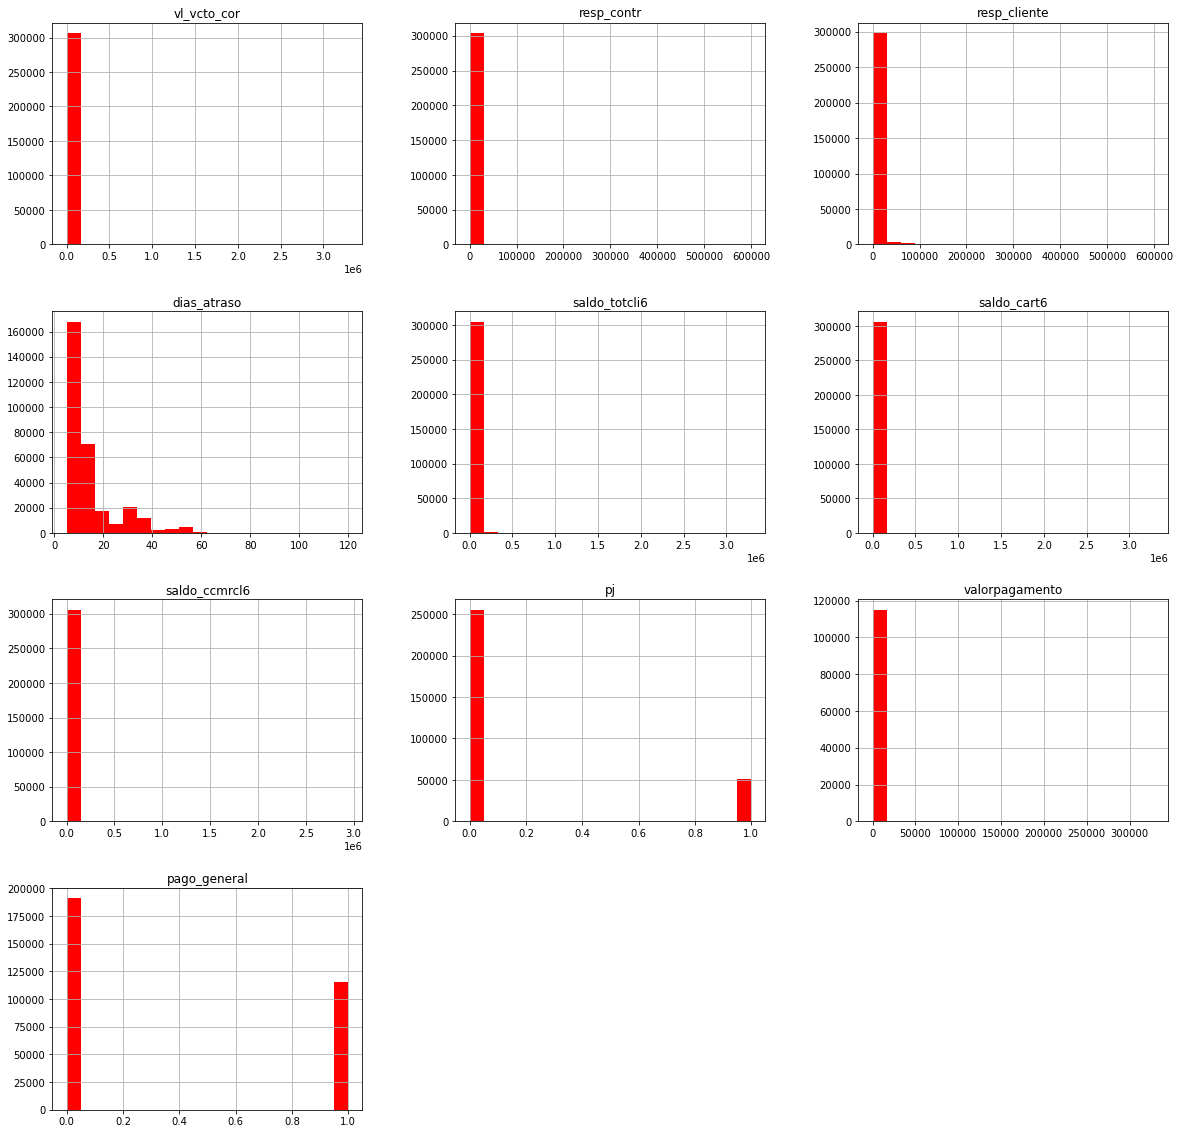

In [13]:
df.hist(bins = 20, figsize = (20,20), color = 'r')

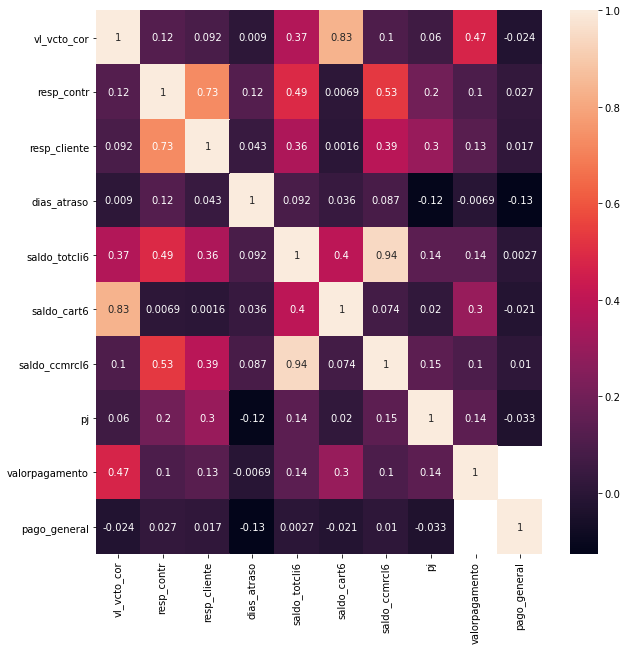

In [14]:
plt.figure(figsize = (10,10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot = True)
plt.show()

In [15]:
print(list(df.columns))

['location', 'banco', 'agencia', 'dir_reg', 'dt_nasc', 'uf', 'iden_tel1', 'ddd_tel1', 'iden_tel2', 'ddd_tel2', 'iden_tel3', 'ddd_tel3', 'iden_tel4', 'ddd_tel4', 'iden_tel5', 'ddd_tel5', 'iden_tel6', 'ddd_tel6', 'rating', 'dt_desde', 'nat_oper', 'carteira', 'vcto_antig', 'vl_vcto_cor', 'resp_contr', 'resp_cliente', 'ident_seg', 'produto', 'subproduto', 'familia', 'convenio', 'bs1', 'cs1', 'num_contrato', 'dias_atraso', 'saldo_totcli6', 'saldo_cart6', 'saldo_ccmrcl6', 'dataasig', 'pj', 'cpf11', 'valorpagamento', 'datapagamento', 'pago_general']


drop highly correlated variables

In [16]:
df = df.drop(['saldo_ccmrcl6', 'vl_vcto_cor', 'resp_contr'  ], axis = 1) 

In [17]:
df['location'].value_counts()

101010    254770
010102     30772
301010     20805
Name: location, dtype: int64

In [18]:
df['banco'].value_counts()

       275575
237     30772
Name: banco, dtype: int64

In [19]:
df['agencia'].value_counts()

04025    39936
03750     3659
03726      723
00265      340
00452      301
         ...  
5690         1
0377         1
3711         1
3232         1
3753         1
Name: agencia, Length: 8669, dtype: int64

In [20]:
df = pd.get_dummies(df, columns = ['location', 'banco', 'uf', 'rating', 'ident_seg', 'bs1', 'cs1'], drop_first = True)

In [21]:
def dum_sign(dummy_col, threshold=0.1):
    """ This function returns a dummified dataframe of significant dummies in
    a given column. """

    # removes the bind
    dummy_col = dummy_col.copy()

    # what is the ratio of a dummy in whole column
    count = pd.value_counts(dummy_col) / len(dummy_col)

    # cond whether the ratios is higher than the threshold
    mask = dummy_col.isin(count[count > threshold].index)

    # replace the ones which ratio is lower than the threshold by a special name
    dummy_col[~mask] = "others"

    return pd.get_dummies(dummy_col, prefix=dummy_col.name)

In [22]:
dummy = pd.Series(df['agencia'], name='agencia')
dummy_df= dum_sign(dummy, 0.01)

In [23]:
df = pd.concat([df, dummy_df], axis=1)
df = df.drop('agencia', axis = 1) 

In [24]:
df['dir_reg'].value_counts()

        275575
4264       490
8533       392
8565       385
4669       384
         ...  
4678         3
8761         2
4631         2
4090         1
4024         1
Name: dir_reg, Length: 131, dtype: int64

dir_reg has aprox. 90% blank. will convert column to zero for blanks 1 non-blank

In [25]:
df['dir_reg'] = df['dir_reg'].apply(lambda x: 0 if x == '' else 1)

In [26]:
df['dt_nasc'] = pd.to_datetime(df['dt_nasc'], errors='coerce')

In [27]:
df['age'] = (df['dataasig'] - df['dt_nasc']).astype('<m8[Y]')
df = df.drop('dt_nasc', axis = 1) 

Telephone variables with ddd can be dropped since we can get valid phone count
using the "V" value in the iden columns.

In [28]:
cols = [c for c in df.columns if c.lower()[:3] != 'ddd']
df = df[cols] 

In [29]:
df['iden_tel1'].value_counts()

X    272696
V     33651
Name: iden_tel1, dtype: int64

will replace valid phone value "V" with 1 so we can get a sum of valid phones

In [30]:
df.iloc[:, 1:7] = df.iloc[:, 1:7].replace({'V': 1,'X':0}).fillna(0)

In [31]:
cols = list(df.columns)

In [32]:
cols = cols[1:7]

In [33]:
df['total_phones'] = df[cols].sum(axis=1)

In [34]:
df.drop(cols, axis=1, inplace=True)

create a new tenure variable using dt_desde and dataasig

In [35]:
df['dt_desde'] = pd.to_datetime(df['dt_desde'], errors='coerce')
df['tenure'] = (df['dataasig'] - df['dt_desde']).astype('<m8[Y]')
df = df.drop('dt_desde', axis = 1) 

In [36]:
df['nat_oper'].value_counts()

3      275575
001     10993
090      7936
013      5057
057      2641
093      1989
012      1438
091       343
058       285
033        33
078        17
102        16
092        12
014         8
007         2
005         2
Name: nat_oper, dtype: int64

In [37]:
dummy = pd.Series(df['nat_oper'], name='nat_oper')
dummy_df= dum_sign(dummy, 0.01)

In [38]:
df = pd.concat([df, dummy_df], axis=1)
df = df.drop('nat_oper', axis = 1) 

In [39]:
df['carteira'].value_counts()

       275575
455      7936
722      4426
351      2838
379      2758
842      2640
385      2312
DCC      1989
530      1906
227      1431
331       544
729       373
375       343
773       309
469       308
809       285
EXL        95
GFC        45
266        33
771        32
393        30
532        17
288        15
136        13
340        12
CAF        11
712         8
144         6
621         6
CFF         5
944         5
448         5
226         4
349         4
451         4
117         4
700         2
406         2
404         2
263         2
551         2
591         2
039         1
688         1
124         1
841         1
044         1
321         1
510         1
304         1
Name: carteira, dtype: int64

In [40]:
dummy = pd.Series(df['carteira'], name='carteira')
dummy_df= dum_sign(dummy, 0.005)

In [41]:
df = pd.concat([df, dummy_df], axis=1)
df = df.drop(['carteira', 'vcto_antig', 'familia'], axis = 1) #vcto_antig same as dias_atraso
#familia highly corr with produto

In [42]:
df['produto'].value_counts()

000    277980
004     15608
011      7936
002      2926
005      1531
019       340
012        18
006         8
Name: produto, dtype: int64

In [43]:
df['prod_000'] = df['produto'].apply(lambda x: 0 if x != '000' else 1)
df['prod_004'] = df['produto'].apply(lambda x: 0 if x != '004' else 1)
df['prod_011'] = df['produto'].apply(lambda x: 0 if x != '011' else 1)
df = df.drop('produto', axis = 1)

In [44]:
df['subprod_000'] = df['subproduto'].apply(lambda x: 0 if x != '000' else 1)
df['subprod_006'] = df['subproduto'].apply(lambda x: 0 if x != '006' else 1)
df['subprod_061'] = df['subproduto'].apply(lambda x: 0 if x != '061' else 1)
df = df.drop('subproduto', axis = 1)

In [45]:
df['convenio'].value_counts()

000000000    295104
000004930      2015
000007537      1902
000009151      1136
000009152       678
              ...  
000015423         1
000011085         1
000006030         1
000011110         1
000010078         1
Name: convenio, Length: 186, dtype: int64

In [46]:
dummy = pd.Series(df['convenio'], name='convenio')
dummy_df= dum_sign(dummy, 0.005)

In [47]:
df = pd.concat([df, dummy_df], axis=1)
df = df.drop('convenio', axis = 1)

get unique count of contracts for each cpf

In [48]:

nval_df = df.groupby('cpf11').num_contrato.agg(nvals='nunique')

merge unique contract count df with original df

In [49]:
df = pd.merge(df, nval_df, left_on ='cpf11', right_on = 'cpf11', how='left')

drop the others column from all dummies to avoid dummy trap

In [50]:
cols = [col for col in df.columns if '_others' not in col]
df = df[cols] 

In [51]:
del cols
del nval_df
del dummy
del dummy_df

In [52]:
df['dir_reg'].head()

0    1
1    0
2    0
3    0
4    0
Name: dir_reg, dtype: int64

In [53]:
df['dir_reg'].value_counts()

0    275575
1     30772
Name: dir_reg, dtype: int64

In [54]:
df.dtypes

dir_reg                 int64
resp_cliente            int32
num_contrato           object
dias_atraso             int16
saldo_totcli6         float32
                       ...   
subprod_061             int64
convenio_000000000      uint8
convenio_000004930      uint8
convenio_000007537      uint8
nvals                   int64
Length: 103, dtype: object

get a subset of variables to review in correlation matrix

In [55]:
corr_df = df.iloc[:, np.r_[0:15, 42:103]]

<AxesSubplot:>

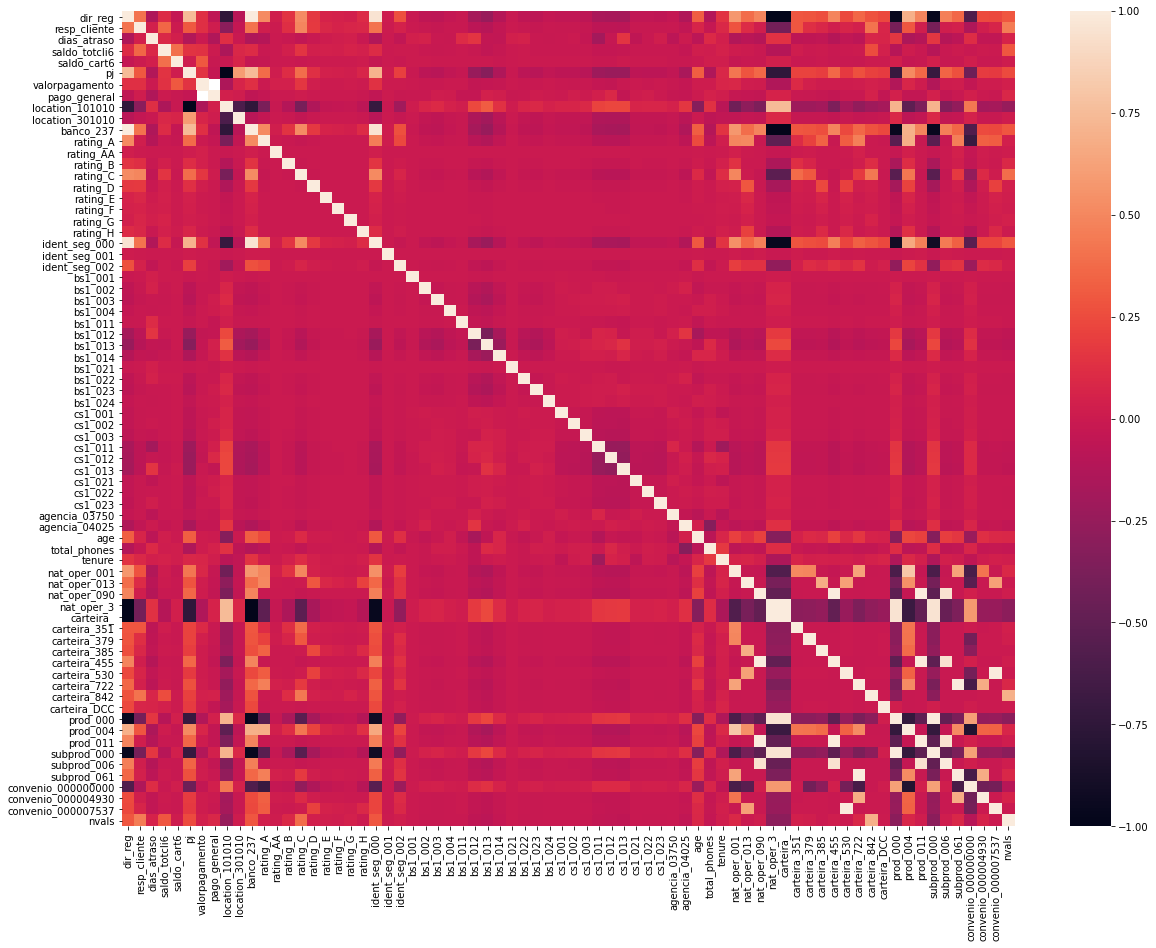

In [56]:
corr_matrix = corr_df.corr()
plt.subplots(figsize=(20,15))
sns.heatmap(corr_matrix)

will drop one of the pairs from too highly correlated variables.

In [57]:
df = df.drop(['dir_reg', 'ident_seg_000', 'nat_oper_090', 'subprod_006', 'subprod_000', 'subprod_061'] , axis = 1)

# Get Cumulative Info for key variables then dedupe by CPF

In [58]:
def trans_max(*args, key):
    """ This function transforms the column by performing a groupby on the key
    column and summing the values."""
    
    for arg in args:
        df[arg] = df[arg].groupby(df[key]).transform('max')
    return df[arg]

In [59]:
trans_max('pj',
          'pago_general', 'location_101010', 'location_301010', 'banco_237',
          'uf_AC', 'uf_AL', 'uf_AM', 'uf_AP', 'uf_BA', 'uf_CE', 'uf_DF',
          'uf_ES', 'uf_GO', 'uf_MA', 'uf_MG', 'uf_MS', 'uf_MT', 'uf_PA',
          'uf_PB', 'uf_PE', 'uf_PI', 'uf_PR', 'uf_RJ', 'uf_RN', 'uf_RO',
          'uf_RR', 'uf_RS', 'uf_SC', 'uf_SE', 'uf_SP', 'uf_TO', 'rating_A',
          'rating_AA', 'rating_B', 'rating_C', 'rating_D', 'rating_E', 'rating_F',
          'rating_G', 'rating_H', 'ident_seg_002',
          'bs1_001', 'bs1_002', 'bs1_003', 'bs1_004', 'bs1_011', 'bs1_012',
          'bs1_013', 'bs1_014', 'bs1_021', 'bs1_022', 'bs1_023', 'bs1_024',
          'cs1_001', 'cs1_002', 'cs1_003', 'cs1_011', 'cs1_012', 'cs1_013',
          'cs1_021', 'cs1_022', 'cs1_023', 'agencia_03750', 'agencia_04025',
          'nat_oper_001', 'nat_oper_013', 'nat_oper_3', 'carteira_',
          'carteira_351', 'carteira_379', 'carteira_385', 'carteira_455',
          'carteira_530', 'carteira_722', 'carteira_842', 'carteira_DCC',
          'prod_000', 'prod_004', 'prod_011', 'convenio_000000000', 'convenio_000004930',
          'convenio_000007537', 'nvals' , key = 'cpf11')

0         1
1         1
2         1
3         1
4         1
         ..
306342    1
306343    1
306344    1
306345    2
306346    2
Name: nvals, Length: 306347, dtype: int64

In [60]:
def trans_sum(*args, key):
    """ This function transforms the column by performing a groupby on the key
    column and summing the values."""
    
    for arg in args:
        df[arg] = df[arg].groupby(df[key]).transform('sum')
    return df[arg]

In [61]:
trans_sum('resp_cliente','total_phones',
          'saldo_totcli6', 'saldo_cart6','valorpagamento', key='cpf11')

0          2369.94
1             0.00
2             0.00
3           368.74
4             0.00
            ...   
306342     5166.47
306343    13378.34
306344     1235.62
306345      664.63
306346      664.63
Name: valorpagamento, Length: 306347, dtype: float64

In [62]:
def trans_mean(*args, key):
    """ This function transform the column by performing a groupby on the key
    column and summing the values."""
   
    for arg in args:
        df[arg] = df[arg].groupby(df[key]).transform('mean')
    return df[arg]

In [63]:
trans_mean('age', 'tenure', 'dias_atraso', key='cpf11')

0          5.00
1         15.00
2         35.00
3         15.00
4          9.00
          ...  
306342     9.00
306343    11.00
306344    15.00
306345     6.25
306346     6.25
Name: dias_atraso, Length: 306347, dtype: float64

In [64]:
df = df.drop_duplicates(subset=['cpf11'])

In [65]:
print(list(df.columns))

['resp_cliente', 'num_contrato', 'dias_atraso', 'saldo_totcli6', 'saldo_cart6', 'dataasig', 'pj', 'cpf11', 'valorpagamento', 'datapagamento', 'pago_general', 'location_101010', 'location_301010', 'banco_237', 'uf_AC', 'uf_AL', 'uf_AM', 'uf_AP', 'uf_BA', 'uf_CE', 'uf_DF', 'uf_ES', 'uf_GO', 'uf_MA', 'uf_MG', 'uf_MS', 'uf_MT', 'uf_PA', 'uf_PB', 'uf_PE', 'uf_PI', 'uf_PR', 'uf_RJ', 'uf_RN', 'uf_RO', 'uf_RR', 'uf_RS', 'uf_SC', 'uf_SE', 'uf_SP', 'uf_TO', 'rating_A', 'rating_AA', 'rating_B', 'rating_C', 'rating_D', 'rating_E', 'rating_F', 'rating_G', 'rating_H', 'ident_seg_001', 'ident_seg_002', 'bs1_001', 'bs1_002', 'bs1_003', 'bs1_004', 'bs1_011', 'bs1_012', 'bs1_013', 'bs1_014', 'bs1_021', 'bs1_022', 'bs1_023', 'bs1_024', 'cs1_001', 'cs1_002', 'cs1_003', 'cs1_011', 'cs1_012', 'cs1_013', 'cs1_021', 'cs1_022', 'cs1_023', 'agencia_03750', 'agencia_04025', 'age', 'total_phones', 'tenure', 'nat_oper_001', 'nat_oper_013', 'nat_oper_3', 'carteira_', 'carteira_351', 'carteira_379', 'carteira_385', 

In [66]:
df = df.drop(['num_contrato', 'dataasig', 'cpf11', 'datapagamento'], axis = 1) 

In [67]:
# split the dataframe into target and features

df_target = df['pago_general']
df_final = df.drop(columns =['pago_general', 'valorpagamento'])

In [68]:
imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(df_final[['age']])
df_final['age'] = imr.transform(df_final[['age']]).ravel()

# PERFORM DIMENSIONALITY REDUCTION USING PCA ( USING SAGEMAKER)

In [ ]:
# standardize the data
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(df_final)

# Apply transform 
df_final = scaler.transform(df_final)


In [ ]:
print(df_final.ndim)

In [ ]:
df_final.nbytes

In [ ]:
import sagemaker
import boto3

# create a Sagemaker session
sagemaker_session = sagemaker.Session()

# define the S3 bucket and prefix that we want to use in this session
bucket = 'bnds-sagemaker-sp'  
prefix = 'cc/pca'  

# get the execution role  

role = sagemaker.get_execution_role()

In [ ]:
import io  
import sagemaker.amazon.common as smac # sagemaker common libary

# Code below converts the data in numpy array format to RecordIO format
# This is the format required by Sagemaker PCA

buf = io.BytesIO() # create an in-memory byte array (buf is a buffer I will be writing to)
df_matrix = df_final # convert the dataframe into 2-dimensional array
smac.write_numpy_to_dense_tensor(buf, df_final)
buf.seek(0)

# When you write to in-memory byte arrays, it increments 1 every time you write to it
# reset that back to zero 

In [ ]:
# Code to upload RecordIO data to S3
 
# Key refers to the name of the file 
 
key = 'pca'

#following code uploads the data in record-io format to S3 bucket to be accessed later for training
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)

# Let's print out the training data location in s3
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)


print('uploaded training data location: {}'.format(s3_train_data))

In [ ]:
# create output placeholder in S3 bucket to store the PCA output

output_location = 's3://{}/{}/output'.format(bucket, prefix)
batch_output = output_location

print('training artifacts will be uploaded to: {}'.format(output_location))

In [ ]:
# This code is used to get the training container of sagemaker built-in algorithms

# obtain a reference to the pca container image

from sagemaker.amazon.amazon_estimator import get_image_uri

container = sagemaker.image_uris.retrieve("pca", boto3.Session().region_name)


In [ ]:
# pass in the container, the type of instance that we would like to use for training 
# output path and sagemaker session into the Estimator. 


pca = sagemaker.estimator.Estimator(container,
                                       role, 
                                       instance_count=1, 
                                       instance_type='ml.c4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=sagemaker_session,
                                       use_spot_instances = True,
                                       max_run = 300,
                                       max_wait = 600)

# We can tune parameters like the number of features that we are passing in, mode of algorithm, mini batch size and number of pca components


pca.set_hyperparameters(feature_dim=91,
                        num_components=40,
                        subtract_mean=False,
                        algorithm_mode='regular',
                        mini_batch_size=100)


# Pass in the training data from S3 to train the pca model


pca.fit({'train': s3_train_data})



Use batch transform for inference instead of deploying endpoint at this time.

In [ ]:
# Create a transformer object
transformer = pca.transformer(
    instance_count=1, 
    instance_type='ml.m4.xlarge',
    max_payload=6,
    strategy='MultiRecord',
    output_path=batch_output
)

In [ ]:
# upload csv version of dataset for use in batch transform instead of invoking endpoint:
pd.DataFrame(df_final).to_csv('test.csv', index=False, header=False)

boto3.Session().resource('s3').Bucket(bucket).Object(
os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')

In [ ]:
# The location of the test dataset
batch_input = 's3://{}/{}/test/test.csv'.format(bucket, prefix)

In [ ]:
# Initiate the batch transform job by executing the transform() method of the transformer object
transformer.transform(
    data=batch_input, 
    data_type='S3Prefix',
    content_type='text/csv',
    split_type='Line'
)
transformer.wait()




# After we have a valid pca reduction model, can restart from here to get a new valid xgboost model

In [69]:
bucket = 'bnds-sagemaker-sp'  
prefix = 'cc/pca' 
result = pd.read_csv('s3://{}/{}/output/test.csv.out'.format(bucket, prefix), header=None)

In [70]:
result.head()

0         1         2         3         4   \
0  {"projection":[-0.190308541059494 -0.431000 -0.455174 -0.541057 -1.320531   
1   {"projection":[0.138418436050415  0.001120  0.301824 -0.211635  0.211533   
2   {"projection":[1.648079633712768  0.773794  0.913804  1.092126  0.954116   
3  {"projection":[-0.610481142997741  0.067148  1.076744 -0.189262  1.391599   
4   {"projection":[0.015675960108637  0.029083 -0.142550  0.018011  0.057127   

         5         6         7         8         9   ...        30        31  \
0 -0.927051 -0.402134 -0.356223  0.835622  0.067943  ...  0.987761 -2.117521   
1 -0.272029 -0.038378 -0.510888 -0.578006 -0.116143  ... -1.632493 -0.455837   
2 -1.231683 -2.190715 -0.796078  3.435923  0.136425  ... -0.456708 -0.203406   
3 -0.870279  2.245078 -0.523610  0.410218  2.408568  ... -0.777368 -0.191408   
4 -0.086045 -0.034934  0.140776  0.280062 -0.279369  ... -1.105049 -0.423532   

         32        33        34        35        36        37        38  \
0  1.448483 -1.196023 -8.947120  1.834282 -3.532674  0.414510  4.433297   
1 -1.050289 -3.471119 -0.414529 -0.923407 -0.138864 -0.199049 -0.066994   
2 -1.349557 -0.463756 -0.249245  0.200184 -0.007000 -0.102534 -0.068636   
3 -0.358977 -0.835111  0.019646 -0.138538 -0.345333  0.218227 -0.265103   
4 -2.338597 -0.002558 -0.546320 -0.531977 -0.451757  0.287398 -0.350299   

                     39  
0  10.465603828430176]}  
1  -0.698013961315155]}  
2  -0.956752598285675]}  
3  -1.088526010513305]}  
4  -0.942629873752594]}  

[5 rows x 40 columns]

In [71]:
replace_values = {'{\"projection\"\:\[': '', '\}':'', '\]':''}
result = result.replace(replace_values, regex=True)  

In [72]:
result.head()

0         1         2         3         4         5   \
0  -0.190308541059494 -0.431000 -0.455174 -0.541057 -1.320531 -0.927051   
1   0.138418436050415  0.001120  0.301824 -0.211635  0.211533 -0.272029   
2   1.648079633712768  0.773794  0.913804  1.092126  0.954116 -1.231683   
3  -0.610481142997741  0.067148  1.076744 -0.189262  1.391599 -0.870279   
4   0.015675960108637  0.029083 -0.142550  0.018011  0.057127 -0.086045   

         6         7         8         9   ...        30        31        32  \
0 -0.402134 -0.356223  0.835622  0.067943  ...  0.987761 -2.117521  1.448483   
1 -0.038378 -0.510888 -0.578006 -0.116143  ... -1.632493 -0.455837 -1.050289   
2 -2.190715 -0.796078  3.435923  0.136425  ... -0.456708 -0.203406 -1.349557   
3  2.245078 -0.523610  0.410218  2.408568  ... -0.777368 -0.191408 -0.358977   
4 -0.034934  0.140776  0.280062 -0.279369  ... -1.105049 -0.423532 -2.338597   

         33        34        35        36        37        38  \
0 -1.196023 -8.947120  1.834282 -3.532674  0.414510  4.433297   
1 -3.471119 -0.414529 -0.923407 -0.138864 -0.199049 -0.066994   
2 -0.463756 -0.249245  0.200184 -0.007000 -0.102534 -0.068636   
3 -0.835111  0.019646 -0.138538 -0.345333  0.218227 -0.265103   
4 -0.002558 -0.546320 -0.531977 -0.451757  0.287398 -0.350299   

                   39  
0  10.465603828430176  
1  -0.698013961315155  
2  -0.956752598285675  
3  -1.088526010513305  
4  -0.942629873752594  

[5 rows x 40 columns]

In [73]:
# access the scores by iterating through the scores in the predictions
predictions = np.array(result)

In [74]:
predictions

array([['-0.190308541059494', -0.430999755859375, -0.455173879861831,
        ..., 0.41451013088226296, 4.433296680450439,
        '10.465603828430176'],
       ['0.138418436050415', 0.001119523658417, 0.301824241876602, ...,
        -0.199048861861228, -0.066993743181228, '-0.698013961315155'],
       ['1.648079633712768', 0.773794412612915, 0.9138041138648979, ...,
        -0.102533660829067, -0.068636484444141, '-0.956752598285675'],
       ...,
       ['0.017564490437507', 0.027563590556382998, 0.119562357664108,
        ..., -0.231470391154289, 0.062455732375382995,
        '-0.640268504619598'],
       ['-0.559277713298797', 0.084126412868499, -0.473675400018692, ...,
        0.203071177005767, -0.20091356337070398, '-0.890457272529602'],
       ['-0.169272899627685', 0.390179187059402, 0.977512538433075, ...,
        0.304942697286605, -0.232443019747734, '-0.855514705181121']],
      dtype=object)

In [75]:
predictions.shape

(264534, 40)

#  TRAIN AND EVALUATE XGBOOST MODEL ON DATA AFTER DIMENSIONALITY REDUCTION (USING SAGEMAKER)

In [76]:
predictions.shape

(264534, 40)

In [77]:
# Convert the array into dataframe in a way that target variable is set as the first column and is followed by feature columns
# This is because sagemaker built-in algorithm expects the data in this format
# train_data: start with dependent variable in first column:

train_data = pd.DataFrame({'Target':df_target})
train_data

Target
0            1
1            0
2            0
3            1
4            0
...        ...
290431       0
290432       0
290433       1
290434       0
290435       0

[264534 rows x 1 columns]

In [78]:
# then add in the independent variables into the train_data dataset
for i in range(predictions.shape[1]):
    train_data[i] = predictions[:,i]

In [79]:
train_data.head()

Target                   0           1         2          3         4  \
0       1  -0.190308541059494      -0.431 -0.455174  -0.541057  -1.32053   
1       0   0.138418436050415  0.00111952  0.301824  -0.211635  0.211533   
2       0   1.648079633712768    0.773794  0.913804    1.09213  0.954116   
3       1  -0.610481142997741   0.0671484   1.07674  -0.189262    1.3916   
4       0   0.015675960108637   0.0290826  -0.14255  0.0180115  0.057127   

           5          6         7         8  ...        30        31  \
0  -0.927051  -0.402134 -0.356223  0.835622  ...  0.987761  -2.11752   
1  -0.272029 -0.0383781 -0.510888 -0.578006  ...  -1.63249 -0.455837   
2   -1.23168   -2.19071 -0.796078   3.43592  ... -0.456708 -0.203406   
3  -0.870279    2.24508  -0.52361  0.410218  ... -0.777368 -0.191408   
4 -0.0860452 -0.0349339  0.140776  0.280062  ...  -1.10505 -0.423532   

         32         33         34        35          36        37         38  \
0   1.44848   -1.19602   -8.94712   1.83428    -3.53267   0.41451     4.4333   
1  -1.05029   -3.47112  -0.414529 -0.923407   -0.138864 -0.199049 -0.0669937   
2  -1.34956  -0.463756  -0.249245  0.200184 -0.00700023 -0.102534 -0.0686365   
3 -0.358977  -0.835111  0.0196461 -0.138538   -0.345333  0.218227  -0.265103   
4   -2.3386 -0.0025581   -0.54632 -0.531977   -0.451757  0.287398  -0.350299   

                   39  
0  10.465603828430176  
1  -0.698013961315155  
2  -0.956752598285675  
3  -1.088526010513305  
4  -0.942629873752594  

[5 rows x 41 columns]

# Split Dataset into Training, Validation, and Test

In [80]:
# You can change the % in the next line of code to determine split for Training, Validation, and Testing

train_pct = 0.8

train_data_size = int(train_pct * train_data.shape[0])
train_data_size

211627

In [81]:
# shuffle the data in dataframe and then split the dataframe into train, test and validation sets.
# then make test and valid datasets equal to 50% each of the remaining non training observations.

import sklearn

train_data = sklearn.utils.shuffle(train_data)
train = train_data[:train_data_size]



In [82]:
test = train_data[train_data_size:train_data_size + int((len(train_data) - train_data_size) * 0.50)]

In [83]:
valid = train_data[train_data_size + int(len(test)):]

In [84]:
train.shape, test.shape,valid.shape

((211627, 41), (26453, 41), (26454, 41))

In [85]:
X_test, y_test = test.drop(columns = ['Target']), test['Target']

In [86]:
X_train, y_train = train.drop(columns = ['Target']), train['Target']
X_valid, y_valid = valid.drop(columns = ['Target']), valid['Target']

In [87]:
len(y_train)

211627

In [88]:
# save train and valid data as csv files

train.to_csv('train.csv',header = False, index = False)
valid.to_csv('valid.csv',header = False, index = False)


In [89]:
# upload csv version of test dataset for use in batch transform instead of invoking endpoint:
pd.DataFrame(X_test).to_csv('X-test.csv', index=False, header=False)

prefix = 'XGBoost-Classifier'
key = 'X-test.csv'

boto3.Session().resource('s3').Bucket(bucket).Object(
os.path.join(prefix, 'test', key)).upload_file(key)

# Let's print out the batch transform testing data location in s3
s3_test_data = 's3://{}/{}/test/{}'.format(bucket, prefix, key)
print('uploaded test data location: {}'.format(s3_test_data))

uploaded test data location: s3://bnds-sagemaker-sp/XGBoost-Classifier/test/X-test.csv


In [90]:
# upload csv version of test dataset dependent variable for later use in analyzing training metrics:
pd.DataFrame(y_test).to_csv('y-test.csv', index=False, header=False)

prefix = 'XGBoost-Classifier'
key = 'y-test.csv'

boto3.Session().resource('s3').Bucket(bucket).Object(
os.path.join(prefix, 'test', key)).upload_file(key)

# Let's print out the data location in s3
s3_y_test_data = 's3://{}/{}/test/{}'.format(bucket, prefix, key)
print('uploaded y-test data location: {}'.format(s3_y_test_data))

uploaded y-test data location: s3://bnds-sagemaker-sp/XGBoost-Classifier/test/y-test.csv


In [91]:
# upload csv version of training dataset w/o dependent variable for use in batch transform instead of invoking endpoint:
pd.DataFrame(X_train).to_csv('X-train.csv', index=False, header=False)

prefix = 'XGBoost-Classifier'
key = 'X-train.csv'

boto3.Session().resource('s3').Bucket(bucket).Object(
os.path.join(prefix, 'train', key)).upload_file(key)

# Let's print out the batch transform training data location in s3
s3_Xtrain_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded X-train data location: {}'.format(s3_Xtrain_data))

uploaded X-train data location: s3://bnds-sagemaker-sp/XGBoost-Classifier/train/X-train.csv


In [92]:
# upload csv version of training dependent variable dataset for later use in analyzing training metrics:
pd.DataFrame(y_train).to_csv('y-train.csv', index=False, header=False)

prefix = 'XGBoost-Classifier'
key = 'y-train.csv'

boto3.Session().resource('s3').Bucket(bucket).Object(
os.path.join(prefix, 'train', key)).upload_file(key)

# Let's print out the y training data location in s3
s3_y_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded y-train data location: {}'.format(s3_y_train_data))

uploaded y-train data location: s3://bnds-sagemaker-sp/XGBoost-Classifier/train/y-train.csv


In [93]:
# upload csv version of validation dataset w/o dependent variable for use in batch transform instead of invoking endpoint:
pd.DataFrame(X_valid).to_csv('X-valid.csv', index=False, header=False)

prefix = 'XGBoost-Classifier'
key = 'X-valid.csv'

boto3.Session().resource('s3').Bucket(bucket).Object(
os.path.join(prefix, 'valid', key)).upload_file(key)

# Let's print out the batch transform valid data location in s3
s3_Xvalid_data = 's3://{}/{}/valid/{}'.format(bucket, prefix, key)
print('uploaded X-valid data location: {}'.format(s3_Xvalid_data))

uploaded X-valid data location: s3://bnds-sagemaker-sp/XGBoost-Classifier/valid/X-valid.csv


In [94]:
# upload csv version of dependent variable for the validation dataset for use later in analyzing training metrics:
pd.DataFrame(y_valid).to_csv('y-valid.csv', index=False, header=False)

prefix = 'XGBoost-Classifier'
key = 'y-valid.csv'

boto3.Session().resource('s3').Bucket(bucket).Object(
os.path.join(prefix, 'valid', key)).upload_file(key)

# Let's print out the batch transform valid data location in s3
s3_y_valid_data = 's3://{}/{}/valid/{}'.format(bucket, prefix, key)
print('uploaded y-valid data location: {}'.format(s3_y_valid_data))

uploaded y-valid data location: s3://bnds-sagemaker-sp/XGBoost-Classifier/valid/y-valid.csv


In [95]:
prefix = 'XGBoost-Classifier'
key = 'train.csv'

In [96]:
# read the data from csv file and then upload the data to s3 bucket
with open('train.csv','rb') as f:
    # The following code uploads the data into S3 bucket to be accessed later for training
    boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(f)

# Let's print out the training data location in s3
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://bnds-sagemaker-sp/XGBoost-Classifier/train/train.csv


In [97]:
prefix = 'XGBoost-Classifier'
key = 'valid.csv'

In [98]:
# reading the data from csv file and then upload the data to s3 bucket
with open('valid.csv','rb') as f:
    # The following code uploads the data into S3 bucket to be accessed later for training
    boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'valid', key)).upload_fileobj(f)

# Let's print out the validation data location in s3
s3_valid_data = 's3://{}/{}/valid/{}'.format(bucket, prefix, key)
print('uploaded validation data location: {}'.format(s3_valid_data))

uploaded validation data location: s3://bnds-sagemaker-sp/XGBoost-Classifier/valid/valid.csv


In [99]:
# creates output placeholder in S3 bucket to store the output

output_location = 's3://{}/{}/output'.format(bucket, prefix)
batch_output = output_location
print('training artifacts will be uploaded to: {}'.format(output_location))

training artifacts will be uploaded to: s3://bnds-sagemaker-sp/XGBoost-Classifier/output


In [100]:
# Create "train", "validation" channels to feed in the model
# Source: https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html

train_input = sagemaker.inputs.TrainingInput(s3_data = s3_train_data, content_type='csv',s3_data_type = 'S3Prefix')
valid_input = sagemaker.inputs.TrainingInput(s3_data = s3_valid_data, content_type='csv',s3_data_type = 'S3Prefix')



In [101]:
# create a Sagemaker session
sagemaker_session = sagemaker.Session()

# get the execution role  

role = sagemaker.get_execution_role()

# This code is used to get the training container of sagemaker built-in algorithms

# obtain a reference to the XGBoost container image

container = sagemaker.image_uris.retrieve("xgboost", boto3.Session().region_name, '0.90-2')


In [102]:
# pass in the container, the type of instance that we would like to use for training 
# output path and sagemaker session into the Estimator. 


Xgboost_classifier = sagemaker.estimator.Estimator(container,
                                       role, 
                                       instance_count=1, 
                                       instance_type='ml.m4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=sagemaker_session,
                                       use_spot_instances = True,
                                       max_run = 300,
                                       max_wait = 600)

# To improve the performance of the model, a hyperparameters tuning job need to be run 

Xgboost_classifier.set_hyperparameters(max_depth=20,
                           eval_metric='auc',
                           objective='binary:logistic',
                           eta = 0.1,
                           num_round = 50,
                           subsample = 1,
                           colsample_bytree = 0.8,
                           gamma = 1            
                           )

In [103]:
# The following cells are for hyperparemeter tuning using random search

In [104]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

# Logarithmic scaling
hyperparameter_ranges = {
    'alpha': ContinuousParameter(0.01, 10, scaling_type="Logarithmic"),
    'lambda': ContinuousParameter(0.01, 10, scaling_type="Logarithmic"),
    'eta': ContinuousParameter(0, 1),
    'max_depth': IntegerParameter(1, 20)
}

In [105]:
objective_metric_name = 'validation:auc'

In [106]:
# Random Search
tuner_log = HyperparameterTuner(
    Xgboost_classifier,
    objective_metric_name,
    hyperparameter_ranges,
    max_jobs=20,
    max_parallel_jobs=10,
    strategy='Random'
)

tuner_log.fit({'train': train_input, 'validation': valid_input}, include_cls_metadata=False)

...........................................................................................................................................................!


In [107]:
# check to see if hyperparameter tuning job started
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_log.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'Completed'

In [108]:
# check jobs have finished
status_log = boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_log.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']
assert status_log == 'Completed', "First must be completed, was {}".format(status_log)


## Get Predictions for Test Dataset

The next four cells are for batch inference from a pre-existing model saved in Sagemaker. Turn these cells on or off depending
on whether or not you want to use a pre-existing model or a newly created one during this kernel processing.

In [109]:
from time import gmtime, strftime
import sagemaker
import boto3

Modelname = 'cc-bank-pca-xgboost-random-22-03-2021-16-57' # the fine tuned model name we already have
transformJobName = 'xgboost-test-batch-'+ strftime("%Y-%m-%d-%H-%M-%S", gmtime())

In [110]:
client = boto3.client('sagemaker')

In [111]:
bucket = 'bnds-sagemaker-sp'  
prefix = 'XGBoost-Classifier' 

# The location of the testing dataset
batch_input = 's3://{}/{}/test/X-test.csv'.format(bucket,prefix) # test data used for prediction
output_location = 's3://{}/{}/output'.format(bucket, prefix)
batch_output = output_location

In [112]:
create_batch = client.create_transform_job(
    TransformJobName=transformJobName,
    ModelName=Modelname,
    MaxConcurrentTransforms=0,
    MaxPayloadInMB=6,
    BatchStrategy='MultiRecord',
    TransformInput={
        'DataSource': {
            'S3DataSource': {
                'S3DataType': 'S3Prefix',
                'S3Uri': batch_input 
            }
        },
        'ContentType': 'text/csv',
        'CompressionType': 'None',
        'SplitType': 'Line'
    },
    TransformOutput={
        'S3OutputPath': batch_output,
        'AssembleWith': 'Line'
    },
    TransformResources={
        'InstanceType': 'ml.m4.xlarge',
        'InstanceCount': 1
    }
    )


The next three cells are for getting batch predictions from a newly created model (one that was created during current kernel processing. Turn these cells off if you used the four cells above for inference from a previously stored model.

In [ ]:
# Run this cell to get inference from newly created model via a transformer object

transformer = Xgboost_classifier.transformer(
    instance_count=1, 
    instance_type='ml.m4.xlarge',
    max_payload=6,
    strategy='MultiRecord',
    output_path=batch_output
)

print ('batch transform output uploaded to: {}'.format(batch_output))

In [ ]:
bucket = 'bnds-sagemaker-sp'  
prefix = 'XGBoost-Classifier' 

# The location of the test dataset
batch_input = 's3://{}/{}/test/X-test.csv'.format(bucket, prefix)
print('test data uploaded to: {}'.format(batch_input))

In [ ]:
# Initiate the batch transform job by executing the transform() method of the transformer object
transformer.transform(
    data=batch_input, 
    data_type='S3Prefix',
    content_type='text/csv',
    split_type='Line'
)
transformer.wait()


In [4]:
bucket = 'bnds-sagemaker-sp'  
prefix = 'XGBoost-Classifier' 
XGB_prediction_test = pd.read_csv('s3://{}/{}/output/X-test.csv.out'.format(bucket, prefix), header=None)

In [5]:
len(XGB_prediction_test)

26453

In [6]:
XGB_prediction_test.head()

0
0  0.439361
1  0.453460
2  0.392254
3  0.940238
4  0.328735

In [7]:
predicted_test = np.array(XGB_prediction_test).astype('float32')

In [8]:
predicted_test

array([[0.43936083],
       [0.45345974],
       [0.39225423],
       ...,
       [0.32259288],
       [0.32540217],
       [0.3610658 ]], dtype=float32)

In [9]:
len(XGB_prediction_test)

26453

In [10]:
len(predicted_test)

26453

In [11]:
bucket = 'bnds-sagemaker-sp'  
prefix = 'XGBoost-Classifier' 
y_test = pd.read_csv('s3://{}/{}/test/y-test.csv'.format(bucket, prefix), header=None)

In [12]:
y_test = np.array(y_test)
y_test = y_test.reshape(-1,1)

In [13]:
y_test

array([[0],
       [1],
       [0],
       ...,
       [0],
       [1],
       [0]])

In [14]:
len(y_test)

26453

The next four cells are for batch inference from a pre-existing model saved in Sagemaker. Turn these cells on or off depending
on whether or not you want to use a pre-existing model or a newly created one during this kernel processing.

In [124]:
from time import gmtime, strftime
import sagemaker
import boto3

Modelname = 'cc-bank-pca-xgboost-random-22-03-2021-16-57' # the fine tuned model name we already have
transformJobName = 'xgboost-train-batch-'+ strftime("%Y-%m-%d-%H-%M-%S", gmtime())

In [125]:
client = boto3.client('sagemaker')

In [126]:
bucket = 'bnds-sagemaker-sp'  
prefix = 'XGBoost-Classifier' 

# The location of the training dataset
batch_input = 's3://{}/{}/train/X-train.csv'.format(bucket,prefix) # training data used for prediction
output_location = 's3://{}/{}/output'.format(bucket, prefix)
batch_output = output_location

In [127]:
create_batch = client.create_transform_job(
    TransformJobName=transformJobName,
    ModelName=Modelname,
    MaxConcurrentTransforms=0,
    MaxPayloadInMB=6,
    BatchStrategy='MultiRecord',
    TransformInput={
        'DataSource': {
            'S3DataSource': {
                'S3DataType': 'S3Prefix',
                'S3Uri': batch_input 
            }
        },
        'ContentType': 'text/csv',
        'CompressionType': 'None',
        'SplitType': 'Line'
    },
    TransformOutput={
        'S3OutputPath': batch_output,
        'AssembleWith': 'Line'
    },
    TransformResources={
        'InstanceType': 'ml.m4.xlarge',
        'InstanceCount': 1
    }
    )


The next three cells are for getting batch predictions from a newly created model (one that was created during current kernel processing. Turn these cells off if you used the four cells above for inference from a previously stored model.

In [ ]:
# Run this cell to get inference from newly created model via a transformer object

transformer = Xgboost_classifier.transformer(
    instance_count=1, 
    instance_type='ml.m4.xlarge', 
    output_path=batch_output
)

print ('batch transform output uploaded to: {}'.format(batch_output))

In [ ]:
# The location of the test dataset
batch_input = 's3://{}/{}/train/X-train.csv'.format(bucket, prefix)
print('location of train dataset used for prediction: {}'.format(batch_input))

In [ ]:
# Initiate the batch transform job by executing the transform() method of the transformer object
transformer.transform(
    data=batch_input, 
    data_type='S3Prefix',
    content_type='text/csv', 
    split_type='Line'
)
transformer.wait()


In [15]:
XGB_prediction_train = pd.read_csv('s3://{}/{}/output/X-train.csv.out'.format(bucket, prefix), header=None)


In [16]:
XGB_prediction_train.head()

0
0  0.358273
1  0.503616
2  0.200589
3  0.263944
4  0.154745

In [17]:
XGB_prediction_train

0
0       0.358273
1       0.503616
2       0.200589
3       0.263944
4       0.154745
...          ...
211622  0.350128
211623  0.290991
211624  0.158580
211625  0.348934
211626  0.352346

[211627 rows x 1 columns]

In [18]:
predict_train = np.array(XGB_prediction_train).astype('float32')

In [19]:
predict_train

array([[0.3582734 ],
       [0.5036163 ],
       [0.20058927],
       ...,
       [0.15857975],
       [0.34893402],
       [0.35234633]], dtype=float32)

In [20]:
bucket = 'bnds-sagemaker-sp'  
prefix = 'XGBoost-Classifier' 
y_train = pd.read_csv('s3://{}/{}/train/y-train.csv'.format(bucket, prefix), header=None)

In [21]:
y_train = np.array(y_train)
y_train = y_train.reshape(-1,1)

In [22]:
len(y_train)

211627

In [23]:
y_train

array([[0],
       [1],
       [0],
       ...,
       [0],
       [0],
       [0]])

## Get Predictions for Validation Dataset

The next four cells are for batch inference from a pre-existing model saved in Sagemaker. Turn these cells on or off depending
on whether or not you want to use a pre-existing model or a newly created one during this kernel processing.

In [137]:
from time import gmtime, strftime
import sagemaker
import boto3

Modelname = 'cc-bank-pca-xgboost-random-22-03-2021-16-57' # the fine tuned model name we already have
transformJobName = 'xgboost-valid-batch-'+ strftime("%Y-%m-%d-%H-%M-%S", gmtime())

In [138]:
client = boto3.client('sagemaker')

In [139]:
bucket = 'bnds-sagemaker-sp'  
prefix = 'XGBoost-Classifier' 

# The location of the validation dataset
batch_input = 's3://{}/{}/valid/X-valid.csv'.format(bucket,prefix) # validation data used for prediction
output_location = 's3://{}/{}/output'.format(bucket, prefix)
batch_output = output_location

In [140]:
create_batch = client.create_transform_job(
    TransformJobName=transformJobName,
    ModelName=Modelname,
    MaxConcurrentTransforms=0,
    MaxPayloadInMB=6,
    BatchStrategy='MultiRecord',
    TransformInput={
        'DataSource': {
            'S3DataSource': {
                'S3DataType': 'S3Prefix',
                'S3Uri': batch_input 
            }
        },
        'ContentType': 'text/csv',
        'CompressionType': 'None',
        'SplitType': 'Line'
    },
    TransformOutput={
        'S3OutputPath': batch_output,
        'AssembleWith': 'Line'
    },
    TransformResources={
        'InstanceType': 'ml.m4.xlarge',
        'InstanceCount': 1
    }
    )


The next three cells are for getting batch predictions from a newly created model (one that was created during current kernel processing. Turn these cells off if you used the four cells above for inference from a previously stored model.

In [ ]:
# Run this cell to get inference from newly created model via a transformer object

transformer = Xgboost_classifier.transformer(
    instance_count=1, 
    instance_type='ml.m4.xlarge', 
    output_path=batch_output
)

print ('batch transform output uploaded to: {}'.format(batch_output))

In [ ]:
# The location of the test dataset
batch_input = 's3://{}/{}/valid/X-valid.csv'.format(bucket, prefix)
print('valid data uploaded to: {}'.format(batch_input))

In [ ]:
# Initiate the batch transform job by executing the transform() method of the transformer object
transformer.transform(
    data=batch_input, 
    data_type='S3Prefix',
    content_type='text/csv', 
    split_type='Line'
)
transformer.wait()


In [24]:
XGB_prediction_valid = pd.read_csv('s3://{}/{}/output/X-valid.csv.out'.format(bucket, prefix), header=None)

In [25]:
XGB_prediction_valid.head()

0
0  0.307655
1  0.350801
2  0.409710
3  0.925805
4  0.329522

In [26]:
XGB_prediction_valid

0
0      0.307655
1      0.350801
2      0.409710
3      0.925805
4      0.329522
...         ...
26449  0.282727
26450  0.893769
26451  0.296423
26452  0.085157
26453  0.106198

[26454 rows x 1 columns]

In [27]:
predict_valid = np.array(XGB_prediction_valid).astype('float32')

In [28]:
predict_valid

array([[0.30765548],
       [0.3508012 ],
       [0.40971035],
       ...,
       [0.29642305],
       [0.0851574 ],
       [0.10619846]], dtype=float32)

In [29]:
bucket = 'bnds-sagemaker-sp'  
prefix = 'XGBoost-Classifier' 
y_valid = pd.read_csv('s3://{}/{}/valid/y-valid.csv'.format(bucket, prefix), header=None)

In [30]:
y_valid = np.array(y_valid)
y_valid = y_valid.reshape(-1,1)

In [31]:
y_valid

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

## Plots for Train, Valid and Test

In [34]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, predicted_test)
tr_fpr, tr_tpr, _ = roc_curve(y_train, predict_train)
vr_fpr, vr_tpr, _ = roc_curve(y_valid, predict_valid)

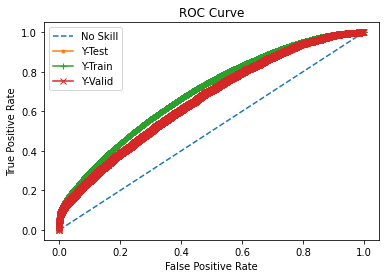

In [35]:
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Y-Test')
plt.plot(tr_fpr, tr_tpr, marker='+', label='Y-Train')
plt.plot(vr_fpr, vr_tpr, marker='x', label='Y-Valid') 

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# title
plt.title('ROC Curve')
# show the plot
plt.show()

In [36]:
auc_test = roc_auc_score(y_test, predicted_test)
print('AUC Test: ',auc_test)
auc_valid = roc_auc_score(y_valid, predict_valid)
print('AUC Validation: ',auc_valid)
auc_train = roc_auc_score(y_train, predict_train)
print('AUC Training: ',auc_train)


AUC Test:  0.6587139937824568
AUC Validation:  0.6601030169714972
AUC Training:  0.6944725743945233


## Confusion Matrix for Training, Validation, and Test datasets

In [37]:
# round predictions for visualization in confusion matrix
predict_train = np.rint(predict_train).astype(int)
predict_valid = np.rint(predict_valid).astype(int)
predicted_test = np.rint(predicted_test).astype(int)

In [38]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [39]:
cm = confusion_matrix(y_train, predict_train)

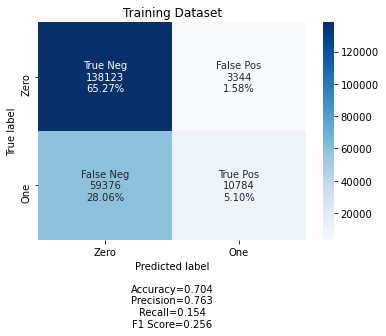

In [40]:
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cm, 
                      group_names=labels,
                      categories=categories,
                      title='Training Dataset')

In [41]:
cm = confusion_matrix(y_valid, predict_valid)

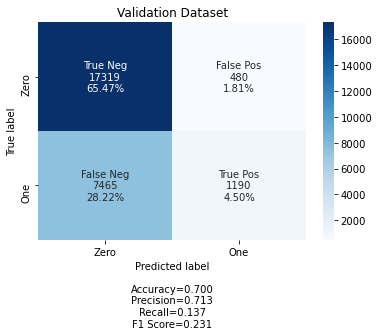

In [42]:
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cm, 
                      group_names=labels,
                      categories=categories,
                      title='Validation Dataset')

In [43]:
cm = confusion_matrix(y_test, predicted_test)

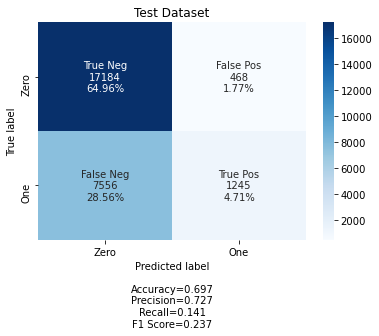

In [44]:
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cm, 
                      group_names=labels,
                      categories=categories,
                      title='Test Dataset')